## Import

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import re
import subprocess
import timeit
import numpy as np
import scipy as sp
import sympy as sy
import pandas as pd
import itertools
import random
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import SubsetRandomSampler

# functions to play animations
from matplotlib import animation
from IPython.display import display

import helper

In [2]:
data_dir = '/home/q1park/data/Cat_Dog_data'

# Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Resize(28),
                                       transforms.CenterCrop(24),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])]) 

test_transforms = transforms.Compose([transforms.Resize(28),
                                      transforms.CenterCrop(24),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5], 
                                                           [0.5, 0.5, 0.5])])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

In [3]:
train_size = 100;
test_size = 100;

train_indices = random.sample(range(1, len(train_data)), train_size)
test_indices = random.sample(range(1, len(test_data)), test_size)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=10, sampler = SubsetRandomSampler(train_indices))
testloader = torch.utils.data.DataLoader(test_data, batch_size=10, sampler = SubsetRandomSampler(test_indices))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


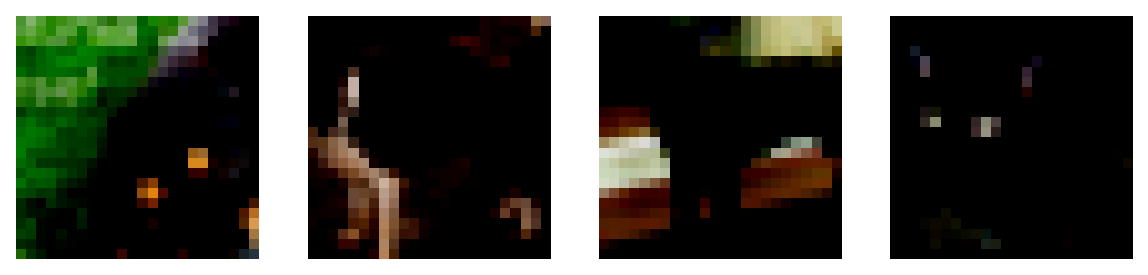

In [4]:
# Change this to the trainloader or testloader 
data_iter = iter(testloader);

images, labels = next(data_iter);
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii];
    helper.imshow(images[ii], ax=ax, normalize=False);

In [5]:
class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
        
        '''
        super().__init__()
        # Input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)


def validation(model, testloader, criterion):
    accuracy = 0
    test_loss = 0
    for images, labels in testloader:

        images = images.resize_(images.size()[0], model.hidden_layers[0].in_features)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ## Calculating the accuracy 
        # Model's output is log-softmax, take exponential to get the probabilities
        ps = torch.exp(output)
        # Class with highest probability is our predicted class, compare with true label
        equality = (labels.data == ps.max(1)[1])
        # Accuracy is number of correct predictions divided by all predictions, just take the mean
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    return test_loss, accuracy


def train(model, trainloader, testloader, criterion, optimizer, epochs=5, print_every=40):

    train_losses, test_losses = [], []
    
    steps = 0
    running_loss = 0
    for e in range(epochs):
        # Model in training mode, dropout is on
        model.train()
        for images, labels in trainloader:
            steps += 1
            # Flatten images into long vector
            images.resize_(images.size()[0], model.hidden_layers[0].in_features)
            
            optimizer.zero_grad()

            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            if steps % print_every == 0:
                # Model in inference mode, dropout is off
                model.eval()
                
                # Turn off gradients for validation, will speed up inference
                with torch.no_grad():
                    test_loss, accuracy = validation(model, testloader, criterion)

                train_losses.append(running_loss/len(trainloader))
                test_losses.append(test_loss/len(testloader))
                
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
                
                running_loss = 0
                
                # Make sure dropout and grads are on for training
                model.train()

1728

torch.Size([10, 3, 24, 24])

In [6]:
# Create the network, define the criterion and optimizer

model = Network(images.view(images.shape[0],-1).shape[1], 2, [20, 20, 20])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
train(model, trainloader, testloader, criterion, optimizer, epochs=2, print_every=2)

Epoch: 1/2..  Training Loss: 0.684..  Test Loss: 0.697..  Test Accuracy: 0.530
Epoch: 1/2..  Training Loss: 0.729..  Test Loss: 0.698..  Test Accuracy: 0.530
Epoch: 1/2..  Training Loss: 0.793..  Test Loss: 0.697..  Test Accuracy: 0.530
Epoch: 1/2..  Training Loss: 0.645..  Test Loss: 0.697..  Test Accuracy: 0.530
Epoch: 1/2..  Training Loss: 0.747..  Test Loss: 0.696..  Test Accuracy: 0.530
Epoch: 2/2..  Training Loss: 0.671..  Test Loss: 0.696..  Test Accuracy: 0.530
Epoch: 2/2..  Training Loss: 0.645..  Test Loss: 0.696..  Test Accuracy: 0.530
Epoch: 2/2..  Training Loss: 0.737..  Test Loss: 0.696..  Test Accuracy: 0.530
Epoch: 2/2..  Training Loss: 0.752..  Test Loss: 0.696..  Test Accuracy: 0.530
Epoch: 2/2..  Training Loss: 0.706..  Test Loss: 0.696..  Test Accuracy: 0.530


In [8]:
checkmark = 'checkpoint_'+'1'+'.pth'

make_checkpoint(model, checkmark)

model_fresh = load_checkpoint(checkmark)
print(model_fresh)

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=1728, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
  )
  (output): Linear(in_features=20, out_features=2, bias=True)
  (dropout): Dropout(p=0.5)
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


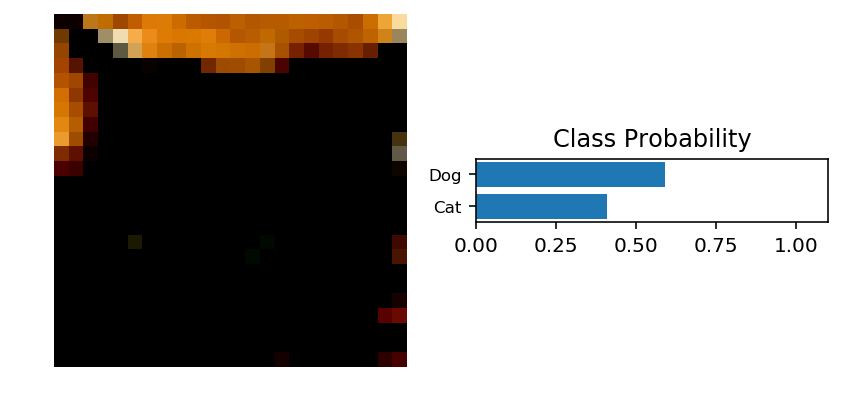

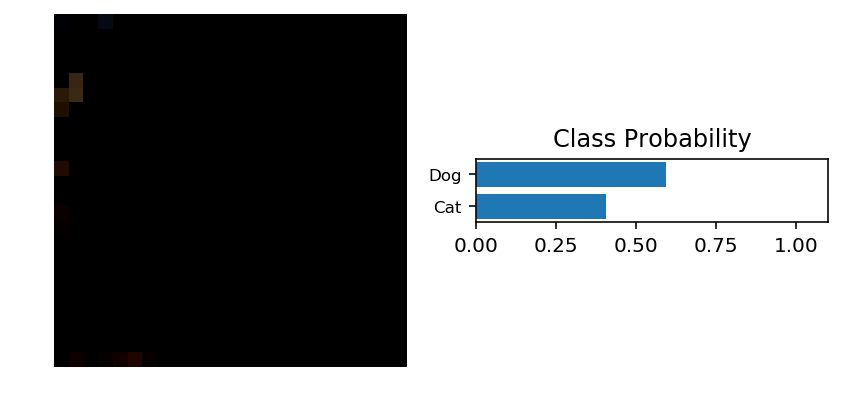

In [9]:
model.eval();

helper.view_probability(model, test_data, 100, version="CatDog");
helper.view_probability(model, test_data, 9, version="CatDog");